<a href="https://colab.research.google.com/github/amousavi9/SRGAN-For-chestXray/blob/main/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.3 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


##Import Libraires

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

##Prepare Data

In [4]:
# defining the size of the image
channels = 3
lr_height = 64
lr_width = 64 
lr_shape = (lr_height, lr_width, channels)
hr_height = lr_height * 4 
hr_width = lr_width * 4  
hr_shape = (hr_height, hr_width, channels)

In [5]:
# Load Data
root_dir = '/content/drive/MyDrive/chest-xray/chest_xray/'
batch_size = 1 # Enhance low resolution single images with super-resolution GAN
image_size = (hr_height, hr_width)

train_ds = keras.preprocessing.image_dataset_from_directory(
    root_dir + 'train',
    batch_size=batch_size,
    image_size=image_size,
    seed=42,
    label_mode=None
)

valid_ds = keras.preprocessing.image_dataset_from_directory(
    root_dir + 'test',
    batch_size=batch_size,
    image_size=image_size,
    seed=42,
    label_mode=None
)

Found 5216 files belonging to 1 classes.
Found 624 files belonging to 1 classes.


##Preprocessing

In [6]:
def scaling(input_image):
    input_image = input_image / 127.5 - 1.
    return input_image


# Scale from (0, 255) to (-1, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

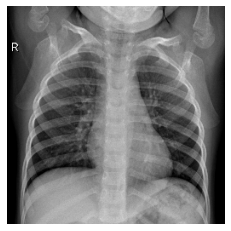

In [7]:
for batch in train_ds.take(1):
    for img in batch:
        plt.imshow(array_to_img(img))
        plt.axis('off')

In [8]:
# resize input
def process_input(input, input_size):
    return tf.image.resize(input, [input_size, input_size], method="area")


train_ds = train_ds.map(
    lambda x: (process_input(x, lr_height), x)
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, lr_height), x)
)
valid_ds = valid_ds.prefetch(buffer_size=32)

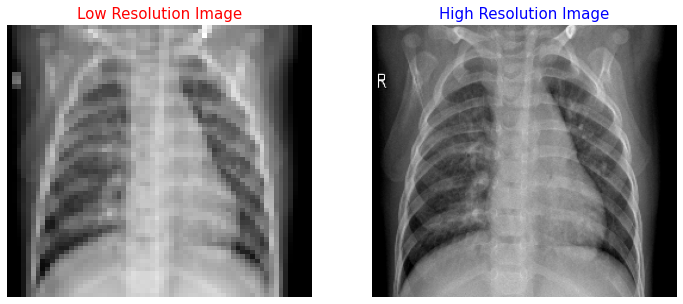

In [36]:
f, ax= plt.subplots(1,2, figsize=(12, 5))
for batch in train_ds.take(2):
    for img in batch[0]:
        ax[0].imshow(array_to_img(img), aspect='auto')
        ax[0].set_title('Low Resolution Image', color='r', fontsize=15)
        ax[0].axis('off')
    for img in batch[1]:
        ax[1].imshow(array_to_img(img), aspect='auto')
        ax[1].set_title('High Resolution Image', color='b', fontsize=15)
        ax[1].axis('off')

##SRGAN-Model

In [10]:
class ConvBock(layers.Layer):
  def __init__(self, n_filters, stride=1, discriminator=False, use_act=True, use_bn=True, **kwargs):
    super().__init__()

    self.use_act = use_act
    self.cnn = layers.Conv2D(filters=n_filters, strides=stride, **kwargs, padding='same', use_bias=not use_bn)
    self.bn = layers.BatchNormalization() if use_bn else layers.Activation('linear')
    self.act = layers.LeakyReLU(0.2) if discriminator else layers.PReLU()

  def call(self, inputs):
    return self.act(self.bn(self.cnn(inputs))) if self.use_act else self.bn(self.cnn(inputs))


class UpsampleBlock(layers.Layer):
  def __init__(self, in_c ,scale_factor):
    super().__init__()

    self.scale_factor = scale_factor
    self.conv = layers.Conv2D(in_c * scale_factor**2, kernel_size=3, padding='same')
    self.act = layers.PReLU()

  def call(self, inputs):
    return self.act(tf.nn.depth_to_space(self.conv(inputs), self.scale_factor))


class ResidualBlock(layers.Layer):
  def __init__(self, in_c, **kwargs):
    super().__init__()

    self.block1 = ConvBock(in_c, kernel_size=3)
    self.block2 = ConvBock(in_c, kernel_size=3, use_act=False)

  def call(self, inputs):
    out = self.block1(inputs)
    out = self.block2(out)
    return out + inputs


class Generator(keras.Model):
  def __init__(self, num_channels=64, num_blocks=16):
    super().__init__()

    self.initial = ConvBock(num_channels, kernel_size=3, use_bn=False)
    self.residual = keras.models.Sequential([ResidualBlock(num_channels) for _ in range(num_blocks)])
    self.convBlock = ConvBock(num_channels, kernel_size=3, use_act=False)
    self.upsamples = keras.models.Sequential([UpsampleBlock(num_channels, scale_factor=2), UpsampleBlock(num_channels, scale_factor=2)])
    self.final = layers.Conv2D(filters=3, kernel_size=9, padding='same')

  def call(self, inputs):
    initial = self.initial(inputs)
    x = self.residual(initial)
    x = self.convBlock(x) + initial
    x = self.upsamples(x)
    return keras.activations.tanh(self.final(x))
  

class Discriminator(keras.Model):
  def __init__(self, features=[64, 64, 128, 128, 256, 256, 512, 512]):
    super().__init__()

    blocks = []
    for idx, feature in enumerate(features):
      blocks.append(
          ConvBock(
              n_filters=feature, 
              kernel_size=3, 
              stride=1 + idx % 2, 
              discriminator=True,
              use_act=True,
              use_bn=False if idx==0 else True)
      )
       
    self.blocks = keras.models.Sequential(blocks)
    self.classifier = keras.models.Sequential([
                                          tfa.layers.AdaptiveAveragePooling2D(output_size=(8, 8)),
                                          layers.Flatten(),
                                          layers.Dense(1024),
                                          layers.LeakyReLU(0.2),
                                          layers.Dense(1, activation='sigmoid')
                                              ])

  def call(self, inputs):
    x = self.blocks(inputs)
    return self.classifier(x)


class VGG(keras.Model):
  def __init__(self, input_shape):
    super().__init__()

    vgg = VGG19(include_top=False, weights="imagenet", input_shape=input_shape)
    self.model = keras.Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)
    self.model.trainable = False
    
  def preprocess_vgg(self, input):
      """Take a HR image [-1, 1], convert to [0, 255], then to input for VGG network"""
      if isinstance(input, np.ndarray):
          return preprocess_input((input+1)*127.5)
      else:            
          return layers.Lambda(lambda x: preprocess_input(tf.add(x, 1) * 127.5))(input)   

  def call(self, inputs):
    return self.model(self.preprocess_vgg(inputs))  


"""Create the combined SRGAN network"""
class SRGAN(keras.Model):
    def __init__(self, gen, disc, vgg):
      super().__init__()

      self.generator = gen
      self.discriminator = disc
      self.vgg = vgg

    def call(self, img_lr):
      fake_hr = self.generator(img_lr) # Generate high res. version from low res.
      fake_features = self.vgg(fake_hr) # Extract image features of the generated img
      validity = discriminator(fake_hr) # Discriminator determines validity of generated high res images
      return validity, fake_features


class SRGAN_Loss(layers.Layer):
  def __init__(self, srgan, vgg):
    super().__init__()

    self.srgan = srgan
    self.vgg = vgg
    self.mse = tf.keras.losses.MeanSquaredError()
    self.cross_entropy = tf.keras.losses.BinaryCrossentropy()

  def discriminator_loss(self, real_output, fake_output):
      valid = np.ones((batch_size,1))
      fake = np.zeros((batch_size,1))
          
      real_loss = self.cross_entropy(valid, real_output)
      fake_loss = self.cross_entropy(fake, fake_output)
      total_loss = 0.5 * (real_loss + fake_loss)
      return total_loss

  def generator_loss(self, imgs_lr, imgs_hr):
      v, img_f = self.srgan(imgs_lr)
      
      image_features = self.vgg(imgs_hr)
      # The generators want the discriminators to label the generated images as real
      valid = np.ones((batch_size,1))
      
      vgg_loss = self.mse(img_f, image_features)
      gan_loss = 1e-3 * self.cross_entropy(v, valid)
      vgg_loss = tf.dtypes.cast(vgg_loss, tf.float64)
      loss = tf.add(gan_loss, vgg_loss)
      return loss  

In [11]:
'''build the generator'''
generator = Generator()
generator.build((1, lr_height, lr_width, channels))
'''build the discriminator'''
discriminator = Discriminator()
discriminator.build((1, hr_height, hr_width, channels))
'''build vgg19'''
vgg = VGG(input_shape=hr_shape)
vgg.build((1, hr_height, hr_width, channels))
'''Build combined'''
srgan = SRGAN(generator, discriminator, vgg)
srgan.build((1, lr_height, lr_width, channels))
'''Build Losses'''
Losses = SRGAN_Loss(srgan, vgg)

80134624/80134624 [==============================] - 4s 0us/step


In [12]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_bock (ConvBock)        multiple                  263936    
                                                                 
 sequential (Sequential)     (1, 64, 64, 64)           5382144   
                                                                 
 conv_bock_33 (ConvBock)     multiple                  37120     
                                                                 
 sequential_1 (Sequential)   (1, 256, 256, 64)         5538304   
                                                                 
 conv2d_36 (Conv2D)          multiple                  15555     
                                                                 
Total params: 11,237,059
Trainable params: 11,232,835
Non-trainable params: 4,224
_________________________________________________________________


In [13]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (1, 16, 16, 512)          4690944   
                                                                 
 sequential_3 (Sequential)   (1, 1)                    33556481  
                                                                 
Total params: 38,247,425
Trainable params: 38,243,713
Non-trainable params: 3,712
_________________________________________________________________


In [14]:
def test(gen, disc):
  low_resolution = 64
  x = tf.random.normal((1, low_resolution, low_resolution, 3))
  gen = Generator()
  gen_out = gen(x)
  disc = Discriminator()
  disc_out = disc(gen_out)

  print('gen_out.shape: ',gen_out.shape)
  print('disc_out.shape: ',disc_out.shape)

In [15]:
test(generator, discriminator)

gen_out.shape:  (1, 256, 256, 3)
disc_out.shape:  (1, 1)


##Helper function

In [16]:
test_loader = iter(valid_ds.window(1))
image_folder_name = "srgan"

In [17]:
def sample_images(epoch):
    os.makedirs('images/%s' % image_folder_name, exist_ok=True)
    r, c = 1, 3

    imgs = next(test_loader)
    imgs_lr = np.array([img.numpy() for img in imgs[0]]).reshape((1,64,64,3))
    imgs_hr = np.array([img.numpy() for img in imgs[1]]).reshape((1,256,256,3))

    fake_hr = generator(imgs_lr, training=False)

    # Rescale images 0 - 1
    imgs_lr = 0.5 * imgs_lr + 0.5
    fake_hr = 0.5 * fake_hr + 0.5
    imgs_hr = 0.5 * imgs_hr + 0.5

    # Save generated images and the high resolution originals
    titles = ['Low Resolution', 'Generated', 'Original']
    colors = ['r', 'g', 'b']
    fig, axs = plt.subplots(r, c, figsize=(16, 6))

    for col, image in enumerate([imgs_lr, fake_hr, imgs_hr]):
        axs[col].imshow(image[0], aspect='auto')
        axs[col].set_title(titles[col], color=colors[col], fontsize=15)
        axs[col].axis('off')
    
    fig.savefig("images/%s/%d.png" % (image_folder_name, epoch))
    plt.close()

##Optimizers

In [18]:
generator_optimizer = keras.optimizers.Adam(0.0002, 0.5)
discriminator_optimizer = keras.optimizers.Adam(0.0002, 0.5)

##Train the model

In [19]:
@tf.function
def train_step(data):

    imgs_lr, imgs_hr = data
        
    with tf.GradientTape() as disc_tape:
        fake_hr = generator(imgs_lr, training=True)

        real_output = discriminator(imgs_hr, training=True)
        fake_output = discriminator(fake_hr, training=True)
        
        disc_loss = Losses.discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        
    with tf.GradientTape() as gen_tape:
        gen_loss = Losses.generator_loss(imgs_lr, imgs_hr)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        
    return gen_loss, disc_loss

In [24]:
def train(epochs, sample_interval=50):

    train_iter = iter(train_ds)
    
    gen_loss = []
    disc_loss = []

    for epoch in range(epochs):
        batch = next(train_iter)
        g_loss, d_loss = train_step(batch)
        
        gen_loss.append(g_loss.numpy())
        disc_loss.append(d_loss.numpy())
        
        # Plot the progress
        if epoch % 20 == 0:
            print ("epoch %s " % (epoch), end=' ')
            tf.print(tf.strings.format("g_loss: {}, d_loss: {}", (g_loss, d_loss)))

        if epoch % sample_interval == 0:
            sample_images(epoch)
            
    return gen_loss, disc_loss

In [25]:
gen_losses, disc_losses = train(epochs = 5000)

epoch 0  g_loss: 116407.26542494835, d_loss: 4.08574413e-22
epoch 20  g_loss: 88587.031331319886, d_loss: 5.7283411e-28
epoch 40  g_loss: 102251.85915768555, d_loss: 1.29674039e-34
epoch 60  g_loss: 84511.601360649642, d_loss: 0
epoch 80  g_loss: 101061.78104845755, d_loss: 0
epoch 100  g_loss: 72735.991987271453, d_loss: 2.36827214e-33
epoch 120  g_loss: 84219.921673000266, d_loss: 1.66210562e-16
epoch 140  g_loss: 66962.991987448477, d_loss: 0
epoch 160  g_loss: 74188.062299948477, d_loss: 3.29857608e-06
epoch 180  g_loss: 82524.055226153563, d_loss: 8.03618502e-20
epoch 200  g_loss: 68287.171875, d_loss: 1.19035255e-15
epoch 220  g_loss: 59176.25, d_loss: 5.0288372
epoch 240  g_loss: 62976.046875, d_loss: 4.86555052
epoch 260  g_loss: 57171.335237441373, d_loss: 2.73274967e-08
epoch 280  g_loss: 55398.683608389583, d_loss: 5.97819103e-13
epoch 300  g_loss: 66310.249799948477, d_loss: 9.57843661e-15
epoch 320  g_loss: 88241.085737448477, d_loss: 8.35306582e-06
epoch 340  g_loss: 3638

## Plot the discriminator and generator loss

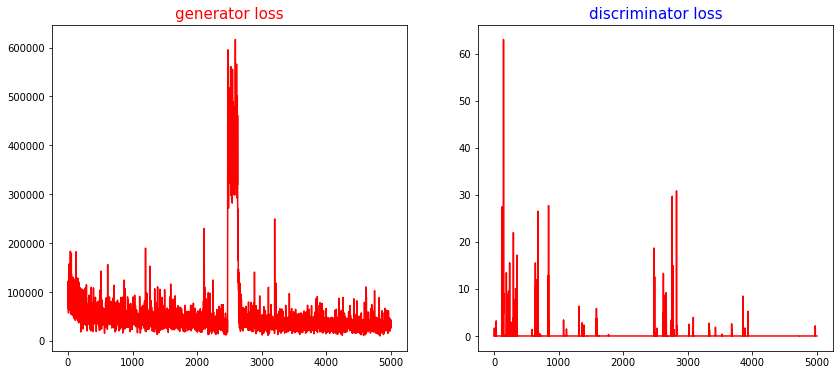

In [39]:
f, ax= plt.subplots(1,2, figsize=(14, 6))
losses = [gen_losses, disc_losses]
titles = ['generator loss', 'discriminator loss']
colors = ['r', 'b']

for c in range(2):
  ax[c].plot(losses[c], color='r')
  ax[c].set_title(titles[c], color=colors[c], fontsize=15)

##save and load generator weights

In [35]:
generator.save_weights('srgan-generator.h5')
#generator.load_weights('srgan-generator.h5')  